In [1]:
category_path = 'upper_category_img/'
category_list = ['hoodie', 'sweatshirt', 'sweater', 'shirt']

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torch.utils.data
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
from PIL import Image


In [3]:
dataset=[]
for category in category_list:
  img_list = os.listdir(category_path + category)
  print(len(img_list), category)
  for img in img_list:
    dataset.append([category_path + category + '/' + img, category])

761 hoodie
620 sweatshirt
667 sweater
778 shirt


In [4]:
print(len(dataset))
print(dataset[0])

2826
['upper_category_img/hoodie/230_0.jpg', 'hoodie']


In [5]:
#for data balancing

count = 620
num_train = 600
num_valid = 20

random.seed(10)

train_data = []
valid_data = []
test_data = []


data_per_cat = {}
balanced_data = []
for category in category_list:
  data_per_cat[category] = [x for x in dataset if x[1] == category]
  balanced_data =balanced_data + random.sample(data_per_cat[category], count)

'''
print(len(balanced_data))
for category in category_list:
  train_data = train_data + [x for x in balanced_data if x[1] == category][:num_train]
  valid_data = valid_data + [x for x in balanced_data if x[1] == category][num_train:num_train + num_valid]
  test_data = test_data + [x for x in balanced_data if x[1] == category][num_train + num_valid:count]
'''
for category in category_list:
  train_data = train_data + [x for x in balanced_data if x[1] == category][-num_train:]
  valid_data = valid_data + [x for x in balanced_data if x[1] == category][:-num_train]



random.shuffle(train_data)
random.shuffle(valid_data)
random.shuffle(test_data)

print(len(train_data), len(valid_data), len(test_data))

2400 80 0


In [6]:
a = [1,2,3,4,5,6,7,8]
print(a[-6:])
print(a[:-6])

[3, 4, 5, 6, 7, 8]
[1, 2]


In [7]:
class upper_category_dataset(torch.utils.data.Dataset):
  def __init__(self, dataset, transforms = None):
    self.dataset = dataset
    self.transforms = transforms
  def __getitem__ (self, idx):
    img_path = os.path.join(self.dataset[idx][0])
    img = Image.open(img_path).convert("RGB")
    
    label = category_list.index(self.dataset[idx][1])
    
    if self.transforms is not None:
      img = self.transforms(img)

    return img, label

  def __len__(self):
    return len(self.dataset)


In [8]:
train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])



In [9]:
train_dataset = upper_category_dataset(train_data, train_transforms)
valid_dataset = upper_category_dataset(valid_data, val_transforms)
test_dataset = upper_category_dataset(test_data, val_transforms)

print(len(train_dataset))


2400


In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = 8, shuffle = False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 2, shuffle = False, num_workers=4)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

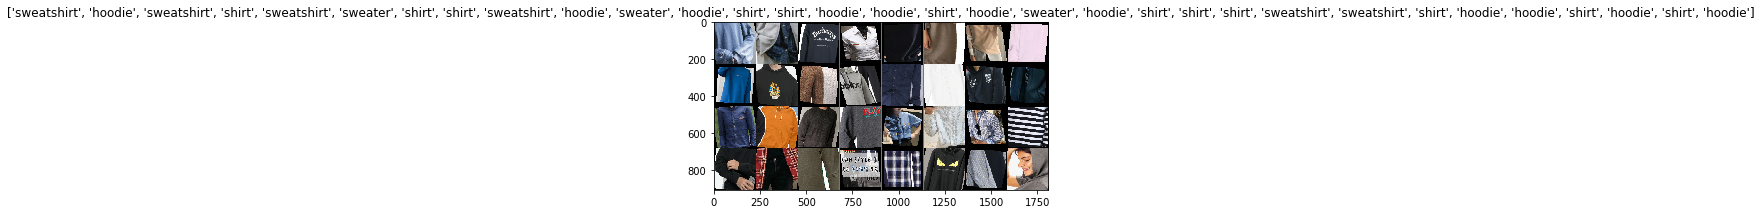

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


inputs, classes = next(iter(train_loader))

out = torchvision.utils.make_grid(inputs)
imshow(out, title = [category_list[x] for x in classes])


In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()

  best_model = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  best_train_acc = 0.0
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-'*10)


    running_train_loss = 0.0
    running_train_corrects = 0
    running_val_loss = 0.0
    running_val_corrects = 0


    for i, data in enumerate(train_loader):
      inputs, labels = data
      model.train()
      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      with torch.set_grad_enabled(True):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
      running_train_loss += loss.item()*inputs.size(0)
      running_train_corrects += torch.sum(preds == labels.data)

      if(i % 100 == 0):
        print("running training loss: {:.4f}".format(loss))
      
    for inputs, labels in valid_loader:
      model.eval()
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)
      running_val_loss += loss.item()*inputs.size(0)
      running_val_corrects += torch.sum(preds == labels.data)


    epoch_train_loss = running_train_loss / len(train_dataset)
    epoch_train_acc = running_train_corrects.double()/len(train_dataset) 
    epoch_val_loss = running_val_loss / len(valid_dataset)
    epoch_val_acc = running_val_corrects.double()/len(valid_dataset)

    if epoch_val_acc > best_acc:
      best_acc = epoch_val_acc
      best_model = copy.deepcopy(model.state_dict())
      path = 'models/'
      #torch.save(model.state_dict(),path+'SGD_new_model_'+str('{:.4f}'.format(best_acc)) + '.pth')
    
    if epoch_train_acc > best_train_acc:
      best_train_acc = epoch_train_acc
      path = 'models/'
      torch.save(model.state_dict(),path+'SGD_train_acc_'+str('{:.4f}'.format(best_train_acc)) + '.pth')
    
    print('Training: Loss: {:.4f} Acc: {:.4f} || Valid: Loss: {:.4f} Acc: {:.4f}'.format(
        epoch_train_loss, epoch_train_acc, epoch_val_loss, epoch_val_acc))
    
    scheduler.step()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  model.load_state_dict(best_model)

  return model




In [16]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft.load_state_dict(torch.load('./models/SGD_model_0.8600.pth'))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.8)

In [17]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=100)

Epoch 0/99
----------
running training loss: 0.3425
Training: Loss: 0.3480 Acc: 0.8679 || Valid: Loss: 0.1610 Acc: 0.9500
Epoch 1/99
----------
running training loss: 0.3043
Training: Loss: 0.3629 Acc: 0.8700 || Valid: Loss: 0.1363 Acc: 0.9375
Epoch 2/99
----------
running training loss: 0.2229
Training: Loss: 0.3192 Acc: 0.8850 || Valid: Loss: 0.0953 Acc: 0.9625
Epoch 3/99
----------
running training loss: 0.0454
Training: Loss: 0.2981 Acc: 0.8958 || Valid: Loss: 0.1367 Acc: 0.9625
Epoch 4/99
----------
running training loss: 0.1575
Training: Loss: 0.2878 Acc: 0.8925 || Valid: Loss: 0.2093 Acc: 0.9125
Epoch 5/99
----------
running training loss: 0.2684
Training: Loss: 0.2947 Acc: 0.8904 || Valid: Loss: 0.1706 Acc: 0.9125
Epoch 6/99
----------
running training loss: 0.2401
Training: Loss: 0.2407 Acc: 0.9192 || Valid: Loss: 0.1646 Acc: 0.9125
Epoch 7/99
----------
running training loss: 0.3121
Training: Loss: 0.2445 Acc: 0.9092 || Valid: Loss: 0.1580 Acc: 0.9500
Epoch 8/99
----------
ru

running training loss: 0.0309
Training: Loss: 0.0900 Acc: 0.9704 || Valid: Loss: 0.1701 Acc: 0.9500
Epoch 68/99
----------
running training loss: 0.0463
Training: Loss: 0.0794 Acc: 0.9733 || Valid: Loss: 0.1795 Acc: 0.9375
Epoch 69/99
----------
running training loss: 0.0407
Training: Loss: 0.0981 Acc: 0.9646 || Valid: Loss: 0.1983 Acc: 0.9250
Epoch 70/99
----------
running training loss: 0.0591
Training: Loss: 0.0702 Acc: 0.9775 || Valid: Loss: 0.1985 Acc: 0.9500
Epoch 71/99
----------
running training loss: 0.1050
Training: Loss: 0.0842 Acc: 0.9738 || Valid: Loss: 0.2286 Acc: 0.9375
Epoch 72/99
----------
running training loss: 0.0171
Training: Loss: 0.0905 Acc: 0.9671 || Valid: Loss: 0.2472 Acc: 0.9250
Epoch 73/99
----------
running training loss: 0.0317
Training: Loss: 0.0828 Acc: 0.9700 || Valid: Loss: 0.1960 Acc: 0.9500
Epoch 74/99
----------
running training loss: 0.1866
Training: Loss: 0.0813 Acc: 0.9721 || Valid: Loss: 0.2099 Acc: 0.9375
Epoch 75/99
----------
running training